In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [2]:
# Load data
customers = pd.read_csv("D:\LAB\zeotap\Data_Science_intern_assignment\dataset\Customers.csv")
transactions = pd.read_csv("D:\LAB\zeotap\Data_Science_intern_assignment\dataset\Transactions.csv")

# Display first few rows of both datasets
print("Customers Data:")
print(customers.head())

print("\nTransactions Data:")
print(transactions.head())

# Check for missing values
print("\nMissing values in Customers:")
print(customers.isnull().sum())

print("\nMissing values in Transactions:")
print(transactions.isnull().sum())

Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067   2024-04-25 7:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  

Missing values in Customers:
Cus

In [3]:
# Data Preprocessing
# Convert TransactionDate and SignupDate to datetime format
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], format='%Y-%m-%d %H:%M:%S')
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], format='%Y-%m-%d')

In [4]:
# Encode categorical variables
label_encoder = LabelEncoder()
customers['Region'] = label_encoder.fit_transform(customers['Region'])

In [5]:
# Aggregate transaction data per customer
customer_transaction_summary = transactions.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'count'],  # Total spend and transaction count
    'TransactionDate': ['max']  # Most recent transaction date
}).reset_index()


In [6]:
# Rename columns for clarity
customer_transaction_summary.columns = ['CustomerID', 'TotalSpend', 'TransactionCount', 'LastTransactionDate']


In [7]:
# Merge with customer data
customer_data = pd.merge(customers, customer_transaction_summary, on='CustomerID', how='left')

# Fill NaN values with 0 (for customers without transactions)
customer_data.fillna({'TotalSpend': 0, 'TransactionCount': 0}, inplace=True)


In [8]:
# Calculate recency (days since last transaction)
customer_data['Recency'] = (customer_data['SignupDate'].max() - customer_data['LastTransactionDate']).dt.days
customer_data['Recency'].fillna(customer_data['Recency'].max(), inplace=True)

# Drop LastTransactionDate and SignupDate (not needed for clustering)
customer_data.drop(columns=['LastTransactionDate', 'SignupDate'], inplace=True)


In [9]:
# Standardize numerical features
scaler = StandardScaler()
numeric_features = ['TotalSpend', 'TransactionCount', 'Recency']
customer_data[numeric_features] = scaler.fit_transform(customer_data[numeric_features])


In [10]:
# Clustering
# Determine the optimal number of clusters using the Elbow method
wcss = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_data[numeric_features])
    wcss.append(kmeans.inertia_)


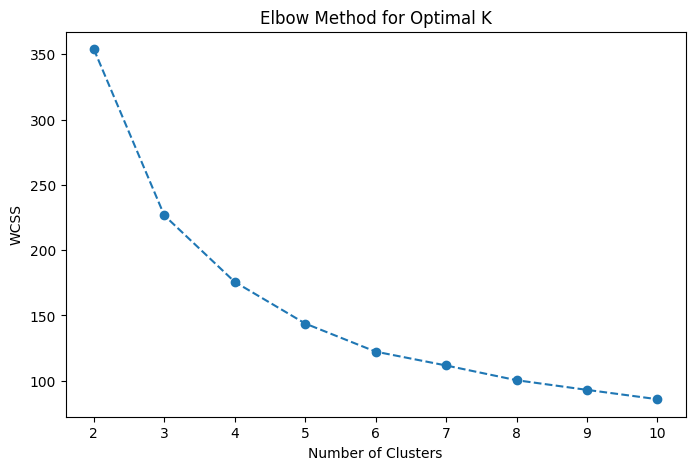

In [11]:

# Plot the Elbow method
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


In [12]:
# Apply K-Means with the chosen number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(customer_data[numeric_features])


In [13]:
# Evaluate Clustering
db_index = davies_bouldin_score(customer_data[numeric_features], customer_data['Cluster'])
sil_score = silhouette_score(customer_data[numeric_features], customer_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {sil_score}')


Davies-Bouldin Index: 1.0041069554457889
Silhouette Score: 0.3139253055723817


In [14]:
# Compute cluster characteristics
cluster_summary = customer_data.groupby('Cluster')[numeric_features].mean().reset_index()

# Rename columns for better readability
cluster_summary.columns = ['Cluster', 'Average Total Spend', 'Average Transaction Count', 'Average Recency']

# Display the cluster characteristics
print(cluster_summary)


   Cluster  Average Total Spend  Average Transaction Count  Average Recency
0        0            -0.756213                  -0.769854        -0.111364
1        1             1.401367                   1.387728        -0.505548
2        2            -1.402035                  -1.611763         2.744307
3        3             0.192260                   0.248790        -0.136226


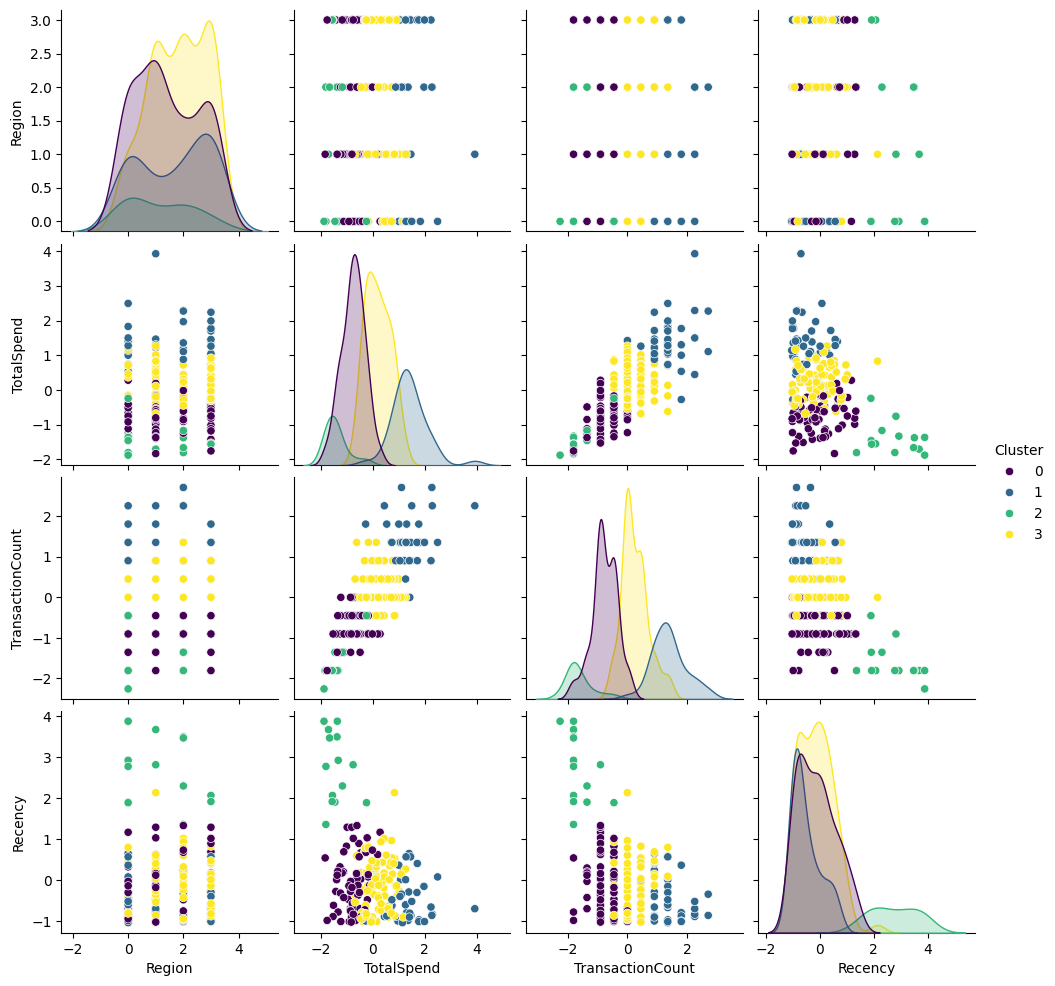

In [15]:
# Visualize Clusters
sns.pairplot(customer_data, hue='Cluster', palette='viridis')
plt.show()


